In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crypto/price_history_data.jsonl
/kaggle/input/crypto/training_data.jsonl
/kaggle/input/crypto/BTC_test_price.jsonl
/kaggle/input/crypto/BTC_test_news.jsonl
/kaggle/input/crypto/requirements.txt
/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import json
import os

In [3]:
# Path to your folder containing .jsonl files
folder_path = r"/kaggle/input/crypto/"

# Initialize an empty list to store the dictionaries from all files
price_history_data_list = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('price_history_data.jsonl'):
        file_path = os.path.join(folder_path, filename)

        # Open and read each file
        with open(file_path, 'r') as file:
            for line in file:
                # Convert each line into a dictionary and append to the list
                price_history_data_list.append(json.loads(line))

price_history_data = {}

In [4]:
price_history_data_list[0]

{'currency': 'BTC',
 'month_year': '2019-09',
 'data': {'this_month_price': 10238.554568886,
  'next_month_price': 8269.028681584,
  'percentage_change': -0.19236366559857992}}

In [5]:
for entry in price_history_data_list:
    if entry['currency'] not in price_history_data:
        price_history_data[entry['currency']]={}
    price_history_data[entry['currency']][entry['month_year']] = {
        'this_month_price': entry['data']['this_month_price'],
        'next_month_price': entry['data']['next_month_price'],
        'percentage_change': entry['data']['percentage_change'],
    }

In [6]:
file_path = r'/kaggle/input/crypto/training_data.jsonl'

# Initialize an empty list to store the dictionaries
training_data_list = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Convert each line into a dictionary and append to the list
        training_data_list.append(json.loads(line))

training_data = {}

for entry in training_data_list:
    if entry['currency'] not in training_data:
        training_data[entry['currency']] = {}
    training_data[entry['currency']][entry['month_year']] = entry['data']

In [7]:
texts=[]
targets=[]

In [8]:
for ticker in price_history_data.keys():
    if ticker in training_data:
        for month_year in price_history_data[ticker].keys():
            if month_year in training_data[ticker]:
                headline=[i['title'] for i in training_data[ticker][month_year]]
                texts.append(headline)
                target=price_history_data[ticker][month_year]['percentage_change']
                targets.append(target)

In [9]:
# Path to GloVe embeddings file
glove_path = r"/kaggle/input/glove-embeddings/glove.6B.100d.txt"

# Create a dictionary to store word embeddings
embedding_index = {}

with open(glove_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [10]:
texts = [" ".join(text) for text in texts]
# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to the same length
max_length = 30  
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [11]:
embedding_dim = 100 
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.float32)

In [13]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [14]:
class LSTMRegressor(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LSTMRegressor, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

In [15]:
# Model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim = 128
output_dim = 1

In [16]:
model = LSTMRegressor(embedding_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [17]:
start_epoch, end_epoch = 1, 50
best_test_loss = float('inf')
best_epoch = 0
avg_train_loss_history, avg_test_loss_history = [], []
avg_train_rmse_history, avg_test_rmse_history = [], []


In [18]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE)
    """
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


In [20]:
# Training loop
for epoch in range(start_epoch, end_epoch + 1):
    # Training Phase
    model.train()
    total_train_loss = 0
    total_train_rmse = 0  # To track the average RMSE during training
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{end_epoch}')
    
    for batch in progress_bar:
        b_input_ids, b_labels = batch
        b_input_ids, b_labels = b_input_ids.to(device), b_labels.to(device)

        optimizer.zero_grad()
        outputs = model(b_input_ids).squeeze()
        loss = loss_fn(outputs, b_labels)
        total_train_loss += loss.item()

        # Calculate RMSE for this batch
        batch_rmse = calculate_rmse(b_labels, outputs)
        total_train_rmse += batch_rmse.item()

        loss.backward()
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch}/{end_epoch} - Train Loss: {loss.item():.2f}, RMSE: {batch_rmse.item():.2f}")
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_rmse = total_train_rmse / len(train_loader)  # Store avg RMSE history
    avg_train_loss_history.append(avg_train_loss)
    avg_train_rmse_history.append(avg_train_rmse)  # Store avg RMSE history
    print(f'Epoch {epoch}/{end_epoch} - Avg Train Loss: {avg_train_loss:.2f}, Avg Train RMSE: {avg_train_rmse:.2f}')

    # Evaluation Phase
    model.eval()
    total_test_loss = 0
    total_test_rmse = 0  # To track the average RMSE during testing
    with torch.no_grad():
        for batch in test_loader:
            b_input_ids, b_labels = batch
            b_input_ids, b_labels = b_input_ids.to(device), b_labels.to(device)

            outputs = model(b_input_ids).squeeze()
            loss = loss_fn(outputs, b_labels)
            total_test_loss += loss.item()

            # Calculate RMSE for this batch
            batch_rmse = calculate_rmse(b_labels, outputs)
            total_test_rmse += batch_rmse.item()

    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_rmse = total_test_rmse / len(test_loader)  # Calculate avg RMSE for test set
    avg_test_loss_history.append(avg_test_loss)
    avg_test_rmse_history.append(avg_test_rmse)  # Store avg RMSE history
    print(f'Epoch {epoch}/{end_epoch} - Avg Test Loss: {avg_test_loss:.2f}, Avg Test RMSE: {avg_test_rmse:.2f}')

    # Keep track of the best epoch
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_epoch = epoch

    # Save the model weights
    model_save_path = f'lstm_model_epoch_{epoch}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved for epoch {epoch} at {model_save_path}')

Epoch 1/50 - Train Loss: 0.05, RMSE: 0.21: 100%|██████████| 295/295 [00:01<00:00, 169.12it/s] 


Epoch 1/50 - Avg Train Loss: 0.53, Avg Train RMSE: 0.45
Epoch 1/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 1 at lstm_model_epoch_1.pth


Epoch 2/50 - Train Loss: 0.02, RMSE: 0.15: 100%|██████████| 295/295 [00:01<00:00, 278.44it/s] 


Epoch 2/50 - Avg Train Loss: 0.53, Avg Train RMSE: 0.46
Epoch 2/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 2 at lstm_model_epoch_2.pth


Epoch 3/50 - Train Loss: 0.01, RMSE: 0.12: 100%|██████████| 295/295 [00:01<00:00, 269.70it/s] 


Epoch 3/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.46
Epoch 3/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 3 at lstm_model_epoch_3.pth


Epoch 4/50 - Train Loss: 0.00, RMSE: 0.06: 100%|██████████| 295/295 [00:01<00:00, 269.82it/s] 


Epoch 4/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.46
Epoch 4/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 4 at lstm_model_epoch_4.pth


Epoch 5/50 - Train Loss: 0.10, RMSE: 0.32: 100%|██████████| 295/295 [00:01<00:00, 252.76it/s] 


Epoch 5/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 5/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 5 at lstm_model_epoch_5.pth


Epoch 6/50 - Train Loss: 0.07, RMSE: 0.27: 100%|██████████| 295/295 [00:01<00:00, 252.65it/s] 


Epoch 6/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 6/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 6 at lstm_model_epoch_6.pth


Epoch 7/50 - Train Loss: 0.01, RMSE: 0.12: 100%|██████████| 295/295 [00:01<00:00, 274.31it/s]


Epoch 7/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.46
Epoch 7/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 7 at lstm_model_epoch_7.pth


Epoch 8/50 - Train Loss: 0.09, RMSE: 0.30: 100%|██████████| 295/295 [00:01<00:00, 270.42it/s] 


Epoch 8/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 8/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 8 at lstm_model_epoch_8.pth


Epoch 9/50 - Train Loss: 0.02, RMSE: 0.13: 100%|██████████| 295/295 [00:01<00:00, 264.27it/s] 


Epoch 9/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 9/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 9 at lstm_model_epoch_9.pth


Epoch 10/50 - Train Loss: 0.03, RMSE: 0.16: 100%|██████████| 295/295 [00:01<00:00, 271.07it/s] 


Epoch 10/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 10/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 10 at lstm_model_epoch_10.pth


Epoch 11/50 - Train Loss: 0.08, RMSE: 0.29: 100%|██████████| 295/295 [00:01<00:00, 270.00it/s] 


Epoch 11/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 11/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 11 at lstm_model_epoch_11.pth


Epoch 12/50 - Train Loss: 0.06, RMSE: 0.25: 100%|██████████| 295/295 [00:01<00:00, 269.93it/s] 


Epoch 12/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 12/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 12 at lstm_model_epoch_12.pth


Epoch 13/50 - Train Loss: 0.11, RMSE: 0.33: 100%|██████████| 295/295 [00:01<00:00, 269.30it/s] 


Epoch 13/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 13/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 13 at lstm_model_epoch_13.pth


Epoch 14/50 - Train Loss: 0.06, RMSE: 0.25: 100%|██████████| 295/295 [00:01<00:00, 270.09it/s] 


Epoch 14/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 14/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 14 at lstm_model_epoch_14.pth


Epoch 15/50 - Train Loss: 0.10, RMSE: 0.32: 100%|██████████| 295/295 [00:01<00:00, 276.16it/s] 


Epoch 15/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 15/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 15 at lstm_model_epoch_15.pth


Epoch 16/50 - Train Loss: 0.01, RMSE: 0.11: 100%|██████████| 295/295 [00:01<00:00, 267.47it/s] 


Epoch 16/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 16/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 16 at lstm_model_epoch_16.pth


Epoch 17/50 - Train Loss: 0.02, RMSE: 0.12: 100%|██████████| 295/295 [00:01<00:00, 267.65it/s] 


Epoch 17/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 17/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 17 at lstm_model_epoch_17.pth


Epoch 18/50 - Train Loss: 0.05, RMSE: 0.22: 100%|██████████| 295/295 [00:01<00:00, 280.60it/s] 


Epoch 18/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 18/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 18 at lstm_model_epoch_18.pth


Epoch 19/50 - Train Loss: 0.06, RMSE: 0.25: 100%|██████████| 295/295 [00:01<00:00, 277.52it/s] 


Epoch 19/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 19/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 19 at lstm_model_epoch_19.pth


Epoch 20/50 - Train Loss: 0.03, RMSE: 0.18: 100%|██████████| 295/295 [00:01<00:00, 274.80it/s]


Epoch 20/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 20/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 20 at lstm_model_epoch_20.pth


Epoch 21/50 - Train Loss: 0.15, RMSE: 0.39: 100%|██████████| 295/295 [00:01<00:00, 275.35it/s] 


Epoch 21/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 21/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 21 at lstm_model_epoch_21.pth


Epoch 22/50 - Train Loss: 0.03, RMSE: 0.18: 100%|██████████| 295/295 [00:01<00:00, 270.72it/s] 


Epoch 22/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 22/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 22 at lstm_model_epoch_22.pth


Epoch 23/50 - Train Loss: 0.11, RMSE: 0.33: 100%|██████████| 295/295 [00:01<00:00, 273.14it/s] 


Epoch 23/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 23/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 23 at lstm_model_epoch_23.pth


Epoch 24/50 - Train Loss: 0.05, RMSE: 0.23: 100%|██████████| 295/295 [00:01<00:00, 273.36it/s] 


Epoch 24/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 24/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 24 at lstm_model_epoch_24.pth


Epoch 25/50 - Train Loss: 0.49, RMSE: 0.70: 100%|██████████| 295/295 [00:01<00:00, 272.40it/s] 


Epoch 25/50 - Avg Train Loss: 0.52, Avg Train RMSE: 0.45
Epoch 25/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 25 at lstm_model_epoch_25.pth


Epoch 26/50 - Train Loss: 0.01, RMSE: 0.11: 100%|██████████| 295/295 [00:01<00:00, 266.94it/s] 


Epoch 26/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 26/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 26 at lstm_model_epoch_26.pth


Epoch 27/50 - Train Loss: 0.07, RMSE: 0.27: 100%|██████████| 295/295 [00:01<00:00, 272.29it/s] 


Epoch 27/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 27/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 27 at lstm_model_epoch_27.pth


Epoch 28/50 - Train Loss: 0.03, RMSE: 0.19: 100%|██████████| 295/295 [00:01<00:00, 269.19it/s] 


Epoch 28/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 28/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 28 at lstm_model_epoch_28.pth


Epoch 29/50 - Train Loss: 0.02, RMSE: 0.13: 100%|██████████| 295/295 [00:01<00:00, 271.75it/s] 


Epoch 29/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 29/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 29 at lstm_model_epoch_29.pth


Epoch 30/50 - Train Loss: 0.01, RMSE: 0.10: 100%|██████████| 295/295 [00:01<00:00, 276.21it/s] 


Epoch 30/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 30/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 30 at lstm_model_epoch_30.pth


Epoch 31/50 - Train Loss: 0.58, RMSE: 0.76: 100%|██████████| 295/295 [00:01<00:00, 282.26it/s] 


Epoch 31/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 31/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 31 at lstm_model_epoch_31.pth


Epoch 32/50 - Train Loss: 0.04, RMSE: 0.19: 100%|██████████| 295/295 [00:01<00:00, 246.00it/s] 


Epoch 32/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 32/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 32 at lstm_model_epoch_32.pth


Epoch 33/50 - Train Loss: 0.03, RMSE: 0.16: 100%|██████████| 295/295 [00:01<00:00, 268.54it/s] 


Epoch 33/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 33/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 33 at lstm_model_epoch_33.pth


Epoch 34/50 - Train Loss: 0.09, RMSE: 0.29: 100%|██████████| 295/295 [00:01<00:00, 266.39it/s] 


Epoch 34/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 34/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 34 at lstm_model_epoch_34.pth


Epoch 35/50 - Train Loss: 0.25, RMSE: 0.50: 100%|██████████| 295/295 [00:01<00:00, 252.68it/s] 


Epoch 35/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 35/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 35 at lstm_model_epoch_35.pth


Epoch 36/50 - Train Loss: 0.03, RMSE: 0.19: 100%|██████████| 295/295 [00:01<00:00, 250.22it/s]


Epoch 36/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 36/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 36 at lstm_model_epoch_36.pth


Epoch 37/50 - Train Loss: 0.07, RMSE: 0.27: 100%|██████████| 295/295 [00:01<00:00, 274.18it/s] 


Epoch 37/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 37/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 37 at lstm_model_epoch_37.pth


Epoch 38/50 - Train Loss: 0.17, RMSE: 0.41: 100%|██████████| 295/295 [00:01<00:00, 269.41it/s] 


Epoch 38/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 38/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 38 at lstm_model_epoch_38.pth


Epoch 39/50 - Train Loss: 0.06, RMSE: 0.24: 100%|██████████| 295/295 [00:01<00:00, 267.24it/s]


Epoch 39/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 39/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 39 at lstm_model_epoch_39.pth


Epoch 40/50 - Train Loss: 0.11, RMSE: 0.33: 100%|██████████| 295/295 [00:01<00:00, 271.09it/s] 


Epoch 40/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 40/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 40 at lstm_model_epoch_40.pth


Epoch 41/50 - Train Loss: 0.11, RMSE: 0.33: 100%|██████████| 295/295 [00:01<00:00, 269.63it/s] 


Epoch 41/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 41/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 41 at lstm_model_epoch_41.pth


Epoch 42/50 - Train Loss: 0.01, RMSE: 0.11: 100%|██████████| 295/295 [00:01<00:00, 264.72it/s] 


Epoch 42/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 42/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 42 at lstm_model_epoch_42.pth


Epoch 43/50 - Train Loss: 0.14, RMSE: 0.38: 100%|██████████| 295/295 [00:01<00:00, 269.00it/s] 


Epoch 43/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 43/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 43 at lstm_model_epoch_43.pth


Epoch 44/50 - Train Loss: 0.39, RMSE: 0.62: 100%|██████████| 295/295 [00:01<00:00, 270.06it/s] 


Epoch 44/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 44/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 44 at lstm_model_epoch_44.pth


Epoch 45/50 - Train Loss: 0.05, RMSE: 0.23: 100%|██████████| 295/295 [00:01<00:00, 267.09it/s] 


Epoch 45/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 45/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 45 at lstm_model_epoch_45.pth


Epoch 46/50 - Train Loss: 0.36, RMSE: 0.60: 100%|██████████| 295/295 [00:01<00:00, 271.80it/s] 


Epoch 46/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 46/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 46 at lstm_model_epoch_46.pth


Epoch 47/50 - Train Loss: 0.10, RMSE: 0.32: 100%|██████████| 295/295 [00:01<00:00, 275.00it/s] 


Epoch 47/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 47/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 47 at lstm_model_epoch_47.pth


Epoch 48/50 - Train Loss: 0.42, RMSE: 0.65: 100%|██████████| 295/295 [00:01<00:00, 270.52it/s] 


Epoch 48/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 48/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 48 at lstm_model_epoch_48.pth


Epoch 49/50 - Train Loss: 0.06, RMSE: 0.25: 100%|██████████| 295/295 [00:01<00:00, 268.64it/s] 


Epoch 49/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 49/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 49 at lstm_model_epoch_49.pth


Epoch 50/50 - Train Loss: 0.04, RMSE: 0.19: 100%|██████████| 295/295 [00:01<00:00, 255.80it/s] 


Epoch 50/50 - Avg Train Loss: 0.51, Avg Train RMSE: 0.45
Epoch 50/50 - Avg Test Loss: 0.30, Avg Test RMSE: 0.41
Model saved for epoch 50 at lstm_model_epoch_50.pth


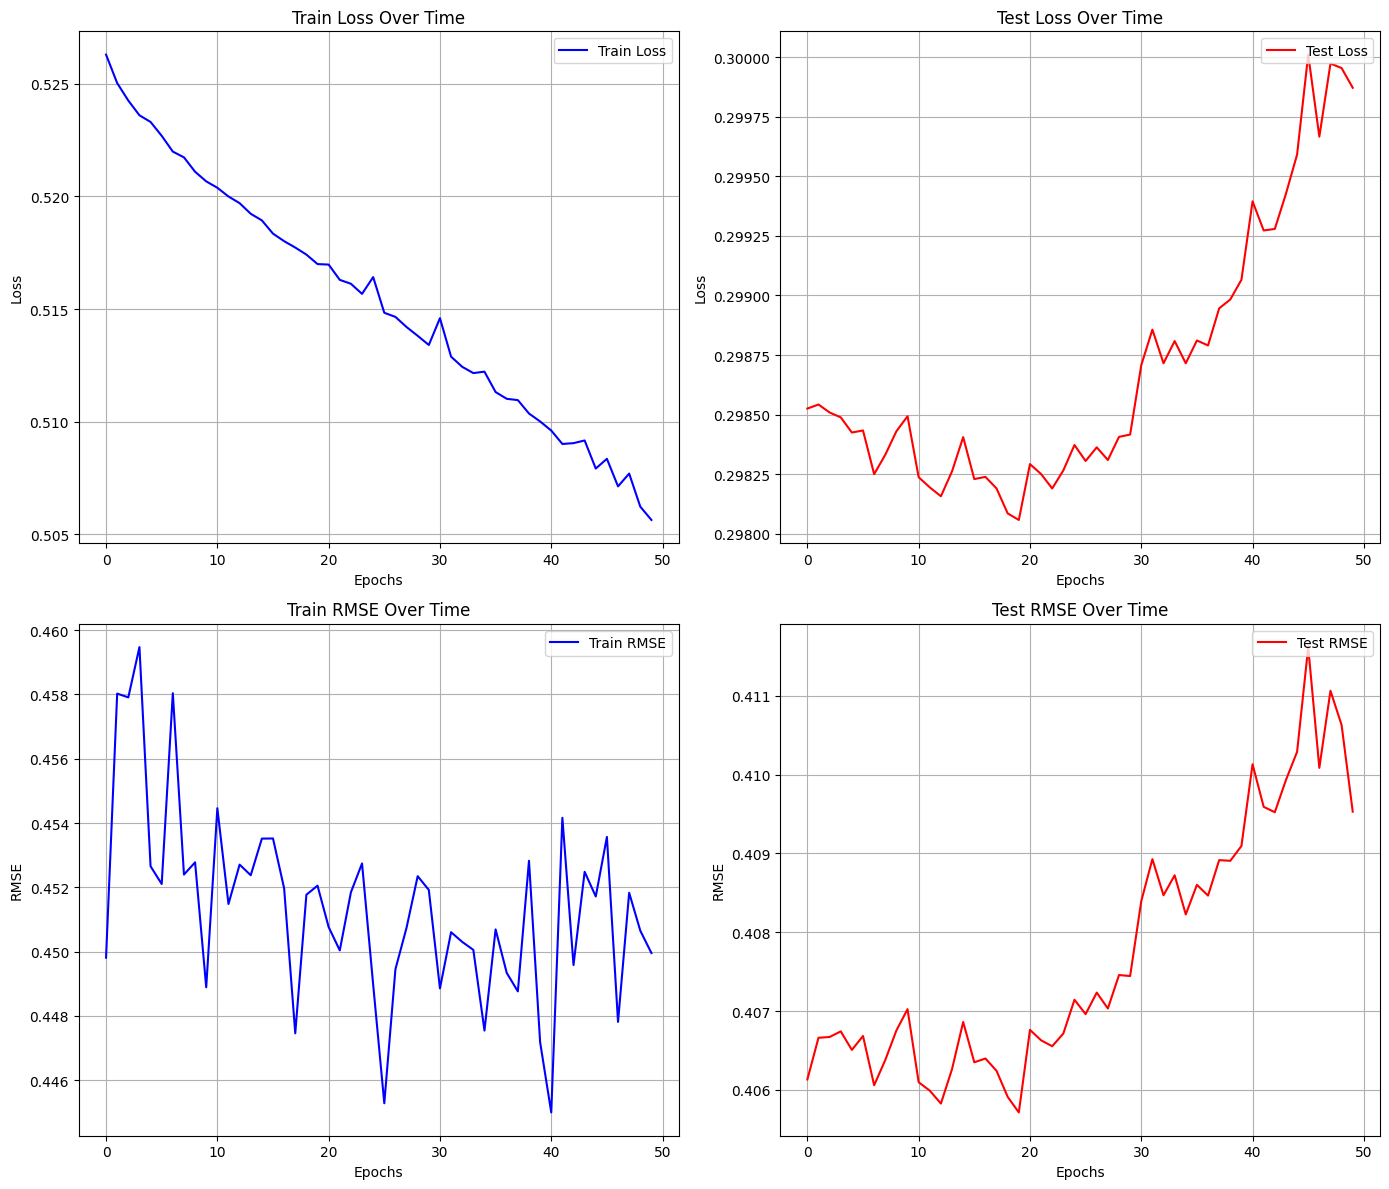

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Plotting the first subplot: Train Loss
ax[0, 0].plot(avg_train_loss_history, linestyle='-', color='b', label='Train Loss')
ax[0, 0].set_title('Train Loss Over Time')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend(loc='upper right')
ax[0, 0].grid(True)

# Plotting the second subplot: Test Loss
ax[0, 1].plot(avg_test_loss_history, linestyle='-', color='r', label='Test Loss')
ax[0, 1].set_title('Test Loss Over Time')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend(loc='upper right')
ax[0, 1].grid(True)

# Plotting the third subplot: Train RMSE
ax[1, 0].plot(avg_train_rmse_history, linestyle='-', color='b', label='Train RMSE')
ax[1, 0].set_title('Train RMSE Over Time')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend(loc='upper right')
ax[1, 0].grid(True)

# Plotting the fourth subplot: Test RMSE
ax[1, 1].plot(avg_test_rmse_history, linestyle='-', color='r', label='Test RMSE')
ax[1, 1].set_title('Test RMSE Over Time')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('RMSE')
ax[1, 1].legend(loc='upper right')
ax[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
print(f"Training complete. Best Test Loss: {best_test_loss:.5f} at epoch {best_epoch}")

Training complete. Best Test Loss: 0.29806 at epoch 20


In [23]:
print("Minimum Test Loss:",min(avg_test_loss_history))
print("Minimum Test RMSE:",min(avg_test_rmse_history))

Minimum Test Loss: 0.2980578542884552
Minimum Test RMSE: 0.40571289893352624
